In [3]:
import collections
import math
import datetime
from tqdm.notebook import trange, tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from numpy import dot
from numpy.linalg import norm

import collections

import re
import numpy as np
import pandas as pd
from pprint import pprint


from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import ml_metrics as metrics
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def create_category_vector(category_map, category_ids_str):
    result = []
    
    category_ids = category_ids_str.split(':')
    
    for category in category_map:
        if str(category) in category_ids:
            result.append(1)
        else:
            result.append(0)
            
    return result

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
cold_start_df = pd.read_csv('2021-04-17_09 15 39_cold_start_data.csv',encoding='cp1251')
cold_start_df.columns = ['user_id', 'event_id', 'is_favorite', 'survey_time']

events_df = pd.read_csv('2021-04-17_11 59 03_cold_start_events.csv', sep=';', encoding='cp1251')
events_df.columns = ['id', 'short_title', 'start_date', 'description', 'is_free', 'place_id', 'place_short_title', 'category_ids', 
                    'category_names', 'category_slags']

actual_events_df = events_df[events_df['id'].isin(cold_start_df['event_id'].unique())]

event_id_name_dict = {k: v for k, v in actual_events_df[['id', 'short_title']].values}

cold_start_df['event_name'] = [event_id_name_dict[event_id] for event_id in cold_start_df['event_id']]

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
uniqual_events_and_dates_df = actual_events_df.groupby(['short_title'])['start_date'].max().reset_index(name='date')
uniqual_events_and_dates_map = {name: (idx, date) for idx, (name, date) in enumerate(uniqual_events_and_dates_df[['short_title', 'date']].values)}

new_ids = []
new_dates = []

for short_title in actual_events_df['short_title'].values:
    new_id, new_date = uniqual_events_and_dates_map[short_title]
    new_ids.append(new_id)
    new_dates.append(new_date)
    
actual_events_df['id'] = new_ids
actual_events_df['start_date'] = new_dates

actual_events_df = actual_events_df.drop_duplicates(subset=['id', 'short_title', 'start_date'], keep='last')

new_ids = []
for event_name in cold_start_df['event_name'].values:
    new_id, new_date = uniqual_events_and_dates_map[event_name]
    new_ids.append(new_id)
    
cold_start_df['event_id'] = new_ids

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-6-a3d7e253e67c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_events_df['id'] = new_ids
<ipython-input-6-a3d7e253e67c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [7]:
category_map = {}

for category_ids_str, category_slags_str in actual_events_df.loc[:, ['category_ids', 'category_slags']].values:
    
    category_ids = category_ids_str.split(':')
    category_slags = category_slags_str.split(':')
    
    for category_id, category_slag in zip(category_ids, category_slags):
        category_map[int(category_id)] = category_slag 
        
category_map = {k: v for k, v in sorted(category_map.items())}

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
category_vectors = []

for category_ids_str in actual_events_df.loc[:, ['category_ids']].values:
    category_vectors.append(create_category_vector(category_map, category_ids_str[0]))

category_vectors_columns = [f'category_{v}' for v in category_map.values()]

category_feactures_dict = collections.defaultdict(list)
for idx, v in enumerate(category_map.values()):
    category_feactures_dict[f'category_{v}'] = [cat_vector[idx] for cat_vector in category_vectors]

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
event_features_df = pd.DataFrame()

event_features_df['id'] = actual_events_df['id']
event_features_df['description'] = actual_events_df['description']

for category, values in category_feactures_dict.items():
    event_features_df[category] = values
    
event_features_df['is_free'] = [1 if is_free else 0 for is_free in actual_events_df['is_free']]

event_features_df['weekday'] = [datetime.datetime.strptime(weekday, "%Y-%m-%d").date().weekday() + 1 for weekday in actual_events_df['start_date']]

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
with open("all_desc.txt", encoding='utf-8') as file:
    all_description = file.read()

event_features_df['all_description'] = all_description.replace('\n', '').split(':::')

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Обработка данных

In [11]:
stop_words = stopwords.words("russian")
stop_words.extend(['сам', 'никто', 'никто', 'свой', 'имя', 'который', 'которой', 'около', 'петербург', 'это'])

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    
    for sent in texts: 
        texts_out.append([morph.normal_forms(word)[0] for word in sent if morph.normal_forms(word)[0] not in stop_words])
        
    return texts_out

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
descriptions = event_features_df['all_description'].values
description_without_urls = [re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) for text in descriptions]

replaced_descriptions = [text.replace('Санкт-Петербург', 'Петербург') for text in description_without_urls]

# Токенизация описаний и очистка текста
description_words  = list(sent_to_words(replaced_descriptions))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(description_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[description_words], threshold=100) 

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Form Bigrams
description_words_bigrams = make_bigrams(description_words)

morph = MorphAnalyzer()

description_words_lemmatized = lemmatization(description_words_bigrams)

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\pymorphy2\units\base.py:70: Deprecation

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(description_words_lemmatized)

# Create Corpus
texts = description_words_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
new_description_corpus_lemmatized = []
description_vocabulary_lemmatized = []
for sent in description_words_lemmatized:
    new_description_corpus_lemmatized.append(' '.join(sent))
    description_vocabulary_lemmatized += sent

description_vocabulary_lemmatized = set(description_vocabulary_lemmatized)

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
pipe = Pipeline([('count', CountVectorizer(vocabulary=description_vocabulary_lemmatized)), ('tfid', TfidfTransformer())]).fit(new_description_corpus_lemmatized)

words_idf = pipe['tfid'].idf_
description_vocabulary_idf = {word: idf for idf, word in zip(words_idf, description_vocabulary_lemmatized)}

stop_words.extend(list({k: v for k, v in sorted(description_vocabulary_idf.items(), key=lambda item: item[1]) if v < 4.5}.keys()))

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Создания тематической модели

In [366]:
n_topics_list = list(range(5, 20))
coherence_ldas = []

for n_topics in n_topics_list:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=description_words_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_ldas.append(coherence_model_lda.get_coherence())

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


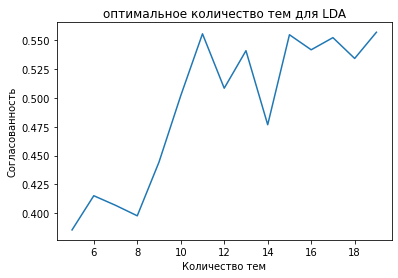

In [367]:
# plot line with x-axis, y-axis and title
plt.plot(n_topics_list, coherence_ldas)
plt.title("оптимальное количество тем для LDA")
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.show()

In [61]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=12,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
lda_model.print_topics()

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.024*"экскурсия" + 0.017*"дворец" + 0.016*"город" + 0.015*"самый" + 0.014*"крыша" + 0.012*"увидеть" + 0.012*"время" + 0.012*"история" + 0.012*"также" + 0.012*"всё"'),
 (1,
  '0.045*"год" + 0.015*"программа" + 0.011*"сергей" + 0.011*"стать" + 0.010*"новый" + 0.009*"яркий" + 0.009*"концерт" + 0.009*"поклонник" + 0.009*"мир" + 0.008*"не_только"'),
 (2,
  '0.026*"мастер" + 0.017*"объединять" + 0.016*"собои" + 0.015*"смысл" + 0.015*"образ" + 0.011*"экспозиция" + 0.010*"давать" + 0.009*"момент" + 0.006*"последний" + 0.006*"культовый"'),
 (3,
  '0.000*"портал" + 0.000*"плод" + 0.000*"соавтор" + 0.000*"серый" + 0.000*"самарканд" + 0.000*"религия" + 0.000*"сталин" + 0.000*"польско" + 0.000*"немец" + 0.000*"освятить"'),
 (4,
  '0.022*"питерский" + 0.012*"улица" + 0.011*"удивительный" + 0.011*"стиль" + 0.008*"современный" + 0.008*"загадочный" + 0.007*"модерн" + 0.007*"рассказать" + 0.007*"архитектура" + 0.007*"основание"'),
 (5,
  '0.026*"группа" + 0.022*"рок" + 0.021*"концерт" + 0.015*"

In [63]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=description_words_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.42759538478129383


In [64]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.268769 -0.058675       1        1  33.545792
1      0.091026  0.089092       2        1  20.155739
7     -0.145534 -0.229391       3        1  17.192325
9     -0.013425  0.006006       4        1  10.487369
5     -0.131298  0.195132       5        1   9.992714
8     -0.021414  0.003250       6        1   3.144666
2     -0.017135  0.000012       7        1   3.043886
4     -0.014182 -0.000235       8        1   2.409516
6     -0.008403 -0.002595       9        1   0.014192
3     -0.008403 -0.002595      10        1   0.013801, topic_info=              Term        Freq       Total Category  logprob  loglift
40             год  125.000000  125.000000  Default   30.000  30.0000
468      экскурсия   82.000000   82.000000  Default   29.000  29.0000
467       участник   38.000000   38.000000  Default   28.000  28.0000
455       прогулка   34.000000   34.000000  Default   27.000  27.0000
517         группа   27.000000   27.000000  Default   26.000  26.0000
..             ...         ...         ...      ...      ...      ...
25            весь    0.000352   28.281653  Topic10   -8.307  -2.4071
26           ветвь    0.000352    0.991497  Topic10   -8.307   0.9436
27   внеконкурсный    0.000352    0.991497  Topic10   -8.307   0.9436
28    возглавившие    0.000352    0.830023  Topic10   -8.307   1.1214
29        возрасти    0.000352    0.830028  Topic10   -8.307   1.1214

[430 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3812      3  0.934244           club
3402      3  0.929725  green_concert
3403      6  0.540824           gspd
3813      3  0.934244          opera
8         2  0.765553           riga
...     ...       ...            ...
1827      3  0.956631            шоу
468       1  0.997503      экскурсия
769       1  0.980290    экскурсовод
381       7  0.957077     экспозиция
261       2  0.963282          яркий

[296 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 8, 10, 6, 9, 3, 5, 7, 4])

## Make recommendations

In [65]:
def generate_topic_vectors_for_texts(lda_model, corpus, n_topics, event_ids):
    topic_vectors = {}
    
    for row, event_id in zip(lda_model[corpus], event_ids):
        dict_row = {k: v for k, v in row[0]}
        topic_vector = []
        for i in range(n_topics):
            if i in dict_row:
                topic_vector.append(round(dict_row[i], 4))
            else:
                topic_vector.append(0)
                
        topic_vectors[event_id] = topic_vector
        
    return topic_vectors

def calculat_user_features(event_topic_modeling_features_dict, users_events_df):
    user_set = set(users_events_df['user_id'])
    
    user_vectors = {}
    for user_id in user_set:
        user_events = users_events_df[users_events_df['user_id'] == user_id]
        user_favorite_events = user_events[user_events['is_favorite'] == True]['event_id'].values
        user_not_favorite_events = user_events[user_events['is_favorite'] == False]['event_id'].values
        
        user_favorite_events_vector =  np.zeros(10) 
        for event_id in user_favorite_events:
            user_favorite_events_vector += np.array(event_topic_modeling_features_dict[event_id])

        user_favorite_events_vector /= len(user_favorite_events)
        
        user_not_favorite_events_vector = np.zeros(10) 
        for event_id in user_not_favorite_events:
            user_not_favorite_events_vector += np.array(event_topic_modeling_features_dict[event_id])

        user_not_favorite_events_vector /= len(user_not_favorite_events)
        
        user_vectors[user_id] = (user_favorite_events_vector, user_not_favorite_events_vector)
    return user_vectors

def calculate_recommendations(event_topic_modeling_features_dict, users_topic_vectors, n_similar):
    user_favorite_ids_dict = {}
    for user_id in users_topic_vectors:
        user_favorite_events_dict = {}
        user_not_favorite_events_dict = {}
        for event_id in event_topic_modeling_features_dict:
            a = users_topic_vectors[user_id][0]
            c = users_topic_vectors[user_id][1]
            b = event_topic_modeling_features_dict[event_id]
            
            user_favorite_events_dict[event_id] = dot(a, b)/(norm(a)*norm(b))
            user_not_favorite_events_dict[event_id] = dot(c, b)/(norm(c)*norm(b))
    
        user_favorite_ids = list({k: v for k, v in sorted(user_favorite_events_dict.items(), key=lambda item: item[1], reverse=True)}.keys())
        user_not_favorite_ids = list({k: v for k, v in sorted(user_not_favorite_events_dict.items(), key=lambda item: item[1], reverse=True)}.keys())
        
        top_worest_events = user_not_favorite_ids[:len(user_not_favorite_ids)//2]
        
        user_favorite_ids_dict[user_id] = [event_id for event_id in user_favorite_ids if event_id not in top_worest_events][:n_similar]
        
    return user_favorite_ids_dict


C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
event_topic_modeling_features_dict = generate_topic_vectors_for_texts(lda_model, corpus, 10, actual_events_df['id'].values)

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
users_topic_vectors = calculat_user_features(event_topic_modeling_features_dict, cold_start_df[['user_id', 'event_id', 'is_favorite']])

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-65-55c8ac97a40b>:30: RuntimeWarning: invalid value encountered in true_divide
  user_favorite_events_vector /= len(user_favorite_events)


In [68]:
user_recommendations = calculate_recommendations(event_topic_modeling_features_dict, users_topic_vectors, 15)

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
id2title = {k: v for k, v in actual_events_df[['id', 'short_title']].values}

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
[id2title[event_id] for event_id in user_recommendations[38089885]]

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Космический джаз',
 'Русские сказки',
 'В гостях у Смешариков',
 'Каста',
 'Петербургский ресторанный фестиваль',
 'Сергей Бобунец',
 'Сектор Газа: Памяти Юрия Хоя',
 'Смешной фестиваль',
 'Музыка во дворце. Моцарт и Шопен',
 'Ольга Максимова',
 'Чиж & Co',
 'Абстрактные миры Бориса Ошкукова',
 'Mgzavrebi',
 'Русское письмо. Книжица о книге',
 'Вечеринки в Comedy Place']

In [71]:
cold_start_df[(cold_start_df['user_id'] == 38089885) & (cold_start_df['is_favorite'] == True)]

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,user_id,event_id,is_favorite,survey_time,event_name
966,38089885,115,True,09:19:36,Ползком по клубам и барам
972,38089885,43,True,09:19:36,Вечеринки в Comedy Place


In [72]:
def calculate_pk(k):
    pk = 0
    for idx, user_id in enumerate(cold_start_df['user_id'].unique()):
        real_event_ids = cold_start_df[(cold_start_df['is_favorite'] == True) & (cold_start_df['user_id'] == user_id)]['event_id'].values
    
        for idx2, prediction_element_id in enumerate(user_recommendations[user_id]):
            if idx2 == k:
                break
                
            if prediction_element_id in real_event_ids:
                pk += 1
                
    return pk / (k * 44)

def calculate_apk(k, df, predictions):
    apk_dict = collections.defaultdict(int)
    
    for idx, user_id in enumerate(df['user_id'].unique()):
        real_event_ids = df[(df['is_favorite'] == True) & (df['user_id'] == user_id)]['event_id'].values
        
        for idx2, prediction_element_id in enumerate(predictions[user_id]):
            if idx2 == k:
                break
                
            if idx2 >= len(real_event_ids):
                break
            
            if prediction_element_id == real_event_ids[idx2]:
                apk_dict[idx2] += 1
    
    return sum([value * calculate_pk(idx + 1) for idx, value in enumerate(apk_dict.values())]) / k / 44

def calculate_user_pk(k, real_user_event_ids, prediction_user_element_ids):
    pk = 0
    
    for idx, prediction_element_id in enumerate(prediction_user_element_ids):
        if idx == k:
            break
            
        if prediction_element_id in real_user_event_ids:
            pk += 1
            
    return pk / k

def calculate_user_apk(k, real_user_event_ids, prediction_user_element_ids):
    apk = 0
    
    for idx, prediction_element_id in enumerate(prediction_user_element_ids):
        if idx == k:
            break
        
        if idx >= len(real_user_event_ids):
            break
        
        if prediction_element_id== real_user_event_ids[idx]:
            apk += 1 * calculate_user_pk(idx + 1, real_user_event_ids, prediction_user_element_ids)
            
    return apk / k

def calculate_mapk(k, df, predictions):
    mapk = 0
    
    for idx, user_id in enumerate(df['user_id'].unique()):
        real_user_event_ids = df[(df['is_favorite'] == True) & (df['user_id'] == user_id)]['event_id'].values
        prediction_user_element_ids = predictions[user_id]
        
        mapk += calculate_user_apk(k, real_user_event_ids, prediction_user_element_ids)
    
    return mapk / 44

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
real_user_event_ids = []
prediction_user_element_ids = []
for user_id in cold_start_df['user_id'].unique():
    real_user_event_ids.append(list(cold_start_df[(cold_start_df['is_favorite'] == True) & (cold_start_df['user_id'] == user_id)]['event_id'].values))
    prediction_user_element_ids.append(user_recommendations[user_id])

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
print(f'5 topics map@10 {round(metrics.mapk(real_user_event_ids, prediction_user_element_ids, 10), 5)}')
print(f'5 topics map@5 {round(metrics.mapk(real_user_event_ids, prediction_user_element_ids, 5), 5)}')

5 topics map@10 0.06164
5 topics map@5 0.06985


C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
print(f'10 topics map@10 {round(metrics.mapk(real_user_event_ids, prediction_user_element_ids, 10), 5)}')
print(f'10 topics map@5 {round(metrics.mapk(real_user_event_ids, prediction_user_element_ids, 5), 5)}')

10 topics map@10 0.07532
10 topics map@5 0.08991


C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [424]:
calculate_mapk(10, cold_start_df, user_recommendations)

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.007681277056277056

In [425]:
calculate_apk(10, cold_start_df, user_recommendations)

C:\Users\Danila\anaconda3\envs\vkr\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0018663911845730027